In [146]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import xavier_initializer
from utils import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import trange
from CharRNN import CharRNN

matplotlib.rc('figure', figsize=(10, 5))

%matplotlib inline

In [19]:
tf.reset_default_graph()

In [3]:
df = pd.read_csv('chembl.csv')

In [4]:
df = df[~pd.isnull(df.acd_logd) & ~pd.isnull(df.acd_logp)]

In [5]:
df['affinity'] = np.zeros(df.shape[0])

In [6]:
def norm(text):
    
    temp = [elems.index(start_elem)] + [elems.index(x) for x in text]
    temp.append(elems.index(end_elem))
    
    return temp

In [7]:
smiles = df.canonical_smiles.apply(norm)

In [8]:
rnn_cell_size = 64
num_layers = 1
embedding_size = 32

split_size = 30
batchsize = 100
epochs = 20
stride=1

num_features = 3

In [20]:
sess = tf.Session()

In [21]:
model = CharRNN(sess, len(elems)+num_features, len(elems), embedding_size, 
                rnn_cell_size, num_layers, len(elems)-1, sess_chkpt='tmp/0_70.chkpt')

INFO:tensorflow:Restoring parameters from tmp/0_70.chkpt


In [22]:
features = df[["acd_logd", "acd_logp", "affinity"]].values

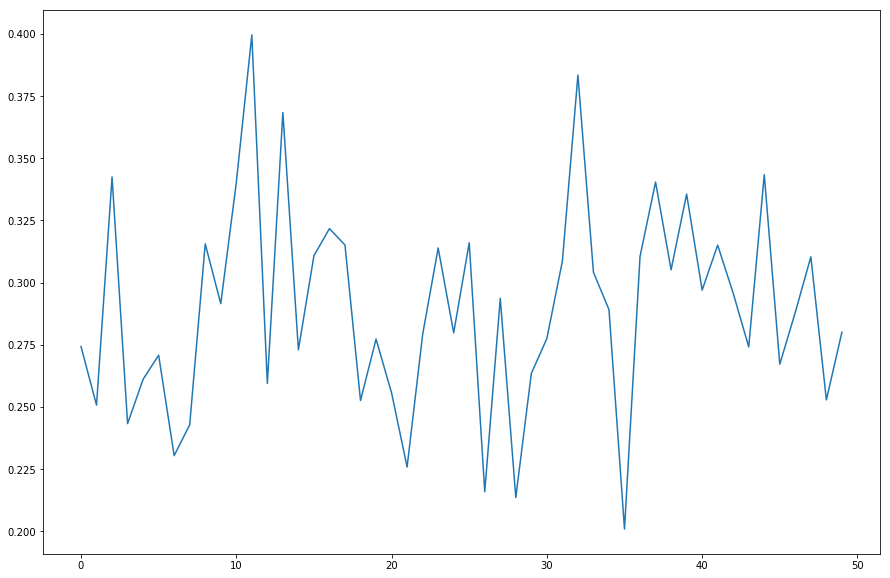

Sample:  FC(F)(F)c1cccc(\c2ccc(Cl)c(OC)c23)cc1OC(CC)(c3ccccc3)C(=O)C5OC(=O)C(=O)[C@H](OC(F)(F)F)C(F)(F)F
Sample:  CCC(=O)OCc1ccc(cc1)c2nc(C3CCC4(C)C(C)(C)c23
Sample:  Cc1ccccc1NC(=O)N[C@H](Cc2cccc(CNC(=O)C)c2Cl)S(=O)(=O)C


KeyboardInterrupt: 

In [78]:
averages = []

for epoch in range(epochs):
    losses = []
    
    print("Epoch number: ", epoch)
    
    for X_batch, Y_batch, lengths in tqdm_notebook(iterate_minibatches(smiles.values, features, batchsize, True), 
                                             total=len(smiles)//batchsize):
        
        loss = model.train_step(X_batch, Y_batch, lengths)
        losses.append(loss)
        
        if len(losses) % 50 == 0:
            clear_output(True)
            plt.figure(figsize=[15, 10])
            plt.plot(losses)
            plt.show()
        
        if len(losses) % 10 == 0:
            
            
            print("Sample: ", to_smile(model.generate_sequence([np.concatenate([feat, start_vec])], 100)))
            
            model.save('tmp/{}_{}.chkpt'.format(epoch, len(losses)))
            
    print("Epoch loss: ", np.mean(losses))
    
    averages.append(np.mean(losses))
    